In [1]:
import numpy as np
import caffe
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import os

%matplotlib inline

%load_ext autoreload
%autoreload 2

from helpers import *
from heatmaps import *

In [2]:
gpu = 0
net_type = 'googlenet'

caffe.set_device(gpu)
caffe.set_mode_gpu()

net = get_net(net_type)

labels_desc = np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_words.txt', str, delimiter='\t')
synsets = np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synsets.txt', str, delimiter='\t')

(paths, labels) = read_imdb('/home/ruthfong/packages/caffe/data/ilsvrc12/animal_parts_require_both_min_10_imdb.txt')
(_, foot_num) = read_imdb('/home/ruthfong/packages/caffe/data/ilsvrc12/animal_parts_require_both_min_10_foot_num_imdb.txt')
(_, eye_num) = read_imdb('/home/ruthfong/packages/caffe/data/ilsvrc12/animal_parts_require_both_min_10_eye_num_imdb.txt')
foot_dir = '/data/ruthfong/ILSVRC2012/animal_parts_dataset/xml/foot'
eye_dir = '/data/ruthfong/ILSVRC2012/animal_parts_dataset/xml/eye'

res_dir = '/data/ruthfong/neural_coding/pycaffe_results'
mask_rel_dir = 'googlenet_animal_parts_given_grad_1_norm_0/min_top0_prob_blur/lr_-1.00_l1_lambda_-4.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_3.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'
mask_paths = [os.path.join(res_dir, mask_rel_dir, '%d.npy' % x) for x in range(len(labels))]
print len(foot_num), len(eye_num), len(labels)

3558 3558 3558


In [3]:
##(_,_) = create_animal_parts_imdb(out_file = '/home/ruthfong/packages/caffe/data/ilsvrc12/animal_parts_imdb.txt')
#out_file = '/home/ruthfong/packages/caffe/data/ilsvrc12/animal_parts_require_both_min_10_imdb.txt'
#foot_num_file = '/home/ruthfong/packages/caffe/data/ilsvrc12/animal_parts_require_both_min_10_foot_num_imdb.txt'
#eye_num_file = '/home/ruthfong/packages/caffe/data/ilsvrc12/animal_parts_require_both_min_10_eye_num_imdb.txt'

#(_,_) = create_animal_parts_imdb(out_file = out_file, 
#                                 foot_num_file = foot_num_file, 
#                                 eye_num_file = eye_num_file, 
#                                 require_eye_and_foot = True, 
#                                 min_per_class = 10)

In [4]:
unique_labels = np.unique(labels)
reverse_indexing = np.loadtxt('/home/ruthfong/packages/caffe/data/ilsvrc12/synset_order_to_ascii_order.txt')
bb_file = '/data/ruthfong/neural_coding/loc_preds/googlenet_animal_parts_gt_pycaffe/saliency/alpha_5.0_norm_Inf.txt'
bb_data = np.loadtxt(bb_file)
bb_labels = bb_data[:,0].astype(int)
bbs = bb_data[:,1:].astype(int)
#for i in range(len(unique_labels)):
for i in range(10):
    label = unique_labels[i]
    idx = np.where(labels == label)[0]
    num_tot_feet = 0
    num_tot_eyes = 0
    num_tot_feet_included = 0
    num_tot_eyes_included = 0
    avg_feet_included = []
    avg_eyes_included = []

    for j in idx:
        foot_included, eye_included = 0, 0
        assert(reverse_indexing[bb_labels[j]]-1 == labels[j])
        (x0,y0,x1,y1) = bbs[i]
        #ax.add_patch(patches.Rectangle((x0,y0),x1-x0,y1-y0,linewidth=1,
        #                               edgecolor='r',facecolor='none'))
        f = paths[j].split('/')[-1].strip('.JPEG') + '.xml'
        foot_ann = os.path.join(foot_dir, f)
        eye_ann = os.path.join(eye_dir, f)
        foot_objs = load_objs(foot_ann)
        eye_objs = load_objs(eye_ann)
        
        #f, ax = plt.subplots(1,1)
        #ax.imshow(caffe.io.load_image(paths[j]))

        num_feet = len(foot_objs['foot'])
        assert(num_feet == foot_num[j])
        #print foot_objs
        for k in range(num_feet):
            (x,y) = foot_objs['foot'][k]
            #ax.add_artist(plt.Circle((x, y), 10, color='g'))
            if (x >= x0 and x <= x1 and y >= y0 and y <= y1):
                foot_included += 1
        #print '%d/%d feet in the bounding box' % (foot_included, num_feet)
        num_eyes = len(eye_objs['eye'])
        assert(num_eyes == eye_num[j])
        #print eye_objs
        for k in range(num_eyes):
            (x,y) = eye_objs['eye'][k]
            #ax.add_artist(plt.Circle((x, y), 10, color='r'))
            if (x >= x0 and x <= x1 and y >= y0 and y <= y1):
                eye_included += 1
        #print '%d/%d eyes in the bounding box' % (eye_included, num_eyes)
        
        num_tot_feet += num_feet
        num_tot_eyes += num_eyes
        num_tot_feet_included += foot_included
        num_tot_eyes_included += eye_included
        avg_feet_included.append(foot_included/float(num_feet))
        avg_eyes_included.append(eye_included/float(num_eyes))
    
    avg_feet_included = np.array(avg_feet_included)
    avg_eyes_included = np.array(avg_eyes_included)

    print '%s (# = %d):' % (get_short_class_name(label), len(idx))
    print '%d/%d = %.4f total feet included (avg = %.4f)' % (
        num_tot_feet_included, num_tot_feet, num_tot_feet_included/float(num_tot_feet),
        avg_feet_included.mean())
    print '%d/%d = %.4f total eyes included (avg = %.4f)' % (
        num_tot_eyes_included, num_tot_eyes, num_tot_eyes_included/float(num_tot_eyes),
        avg_eyes_included.mean())
        #ax.get_xaxis().set_visible(False)
        #ax.get_yaxis().set_visible(False)

indigo bunting (# = 86):
122/144 = 0.8472 total feet included (avg = 0.8547)
86/88 = 0.9773 total eyes included (avg = 0.9767)
robin (# = 81):
22/149 = 0.1477 total feet included (avg = 0.1481)
86/87 = 0.9885 total eyes included (avg = 0.9877)
bulbul (# = 80):
135/138 = 0.9783 total feet included (avg = 0.9812)
18/84 = 0.2143 total eyes included (avg = 0.2000)
magpie (# = 64):
53/119 = 0.4454 total feet included (avg = 0.4570)
66/68 = 0.9706 total eyes included (avg = 0.9766)
chickadee (# = 207):
296/374 = 0.7914 total feet included (avg = 0.7971)
158/215 = 0.7349 total eyes included (avg = 0.7319)
water ouzel (# = 89):
53/163 = 0.3252 total feet included (avg = 0.3427)
74/93 = 0.7957 total eyes included (avg = 0.7978)
spotted salamander (# = 69):
108/177 = 0.6102 total feet included (avg = 0.6341)
61/106 = 0.5755 total eyes included (avg = 0.5652)
tree frog (# = 124):
265/292 = 0.9075 total feet included (avg = 0.9039)
158/171 = 0.9240 total eyes included (avg = 0.9355)
banded gecko (

In [5]:
unique_labels = np.unique(labels)
window_size = 5

mean_eyes_intensity = np.zeros(len(unique_labels))
mean_feet_intensity = np.zeros(len(unique_labels))
stderr_eyes_intensity = np.zeros(len(unique_labels))
stderr_feet_intensity = np.zeros(len(unique_labels))

for i in range(len(unique_labels)):
#for i in range(10):
    label = unique_labels[i]
    idx = np.where(labels == label)[0]
    
    avg_eyes_intensity = []
    avg_feet_intensity = []
    for j in idx:
        heatmap = np.load(mask_paths[j])
        resize = caffe.io.load_image(paths[j]).shape[:2]
        heatmap = imresize(heatmap, resize)/float(255)
        #ax.add_patch(patches.Rectangle((x0,y0),x1-x0,y1-y0,linewidth=1,
        #                               edgecolor='r',facecolor='none'))
        f = paths[j].split('/')[-1].strip('.JPEG') + '.xml'
        foot_ann = os.path.join(foot_dir, f)
        eye_ann = os.path.join(eye_dir, f)
        foot_objs = load_objs(foot_ann)
        eye_objs = load_objs(eye_ann)
        
        #f, ax = plt.subplots(1,1)
        #ax.imshow(caffe.io.load_image(paths[j]))

        num_feet = len(foot_objs['foot'])
        assert(num_feet == foot_num[j])
        #print foot_objs
        for k in range(num_feet):
            (x,y) = foot_objs['foot'][k]
            x, y = int(x), int(y)
            #ax.add_artist(plt.Circle((x, y), 10, color='g'))
            avg_intensity = heatmap[y-(window_size-1)/2:y-(window_size-1)/2+window_size, 
                    x-(window_size-1)/2:x-(window_size-1)/2+window_size].sum()/float(window_size**2)
            avg_feet_intensity.append(avg_intensity)
        #print '%d/%d feet in the bounding box' % (foot_included, num_feet)
        num_eyes = len(eye_objs['eye'])
        assert(num_eyes == eye_num[j])
        #print eye_objs
        for k in range(num_eyes):
            (x,y) = eye_objs['eye'][k]
            x, y = int(x), int(y)
            avg_intensity = heatmap[y-(window_size-1)/2:y-(window_size-1)/2+window_size, 
                    x-(window_size-1)/2:x-(window_size-1)/2+window_size].sum()/float(window_size**2)
            avg_eyes_intensity.append(avg_intensity)
            #ax.add_artist(plt.Circle((x, y), 10, color='r'))
        #print '%d/%d eyes in the bounding box' % (eye_included, num_eyes)
            
    avg_feet_intensity = np.array(avg_feet_intensity)
    avg_eyes_intensity = np.array(avg_eyes_intensity)

    mean_feet_intensity[i] = avg_feet_intensity.mean()
    stderr_feet_intensity[i] = avg_feet_intensity.std()/float(len(avg_feet_intensity)**0.5)
    mean_eyes_intensity[i] = avg_eyes_intensity.mean()
    stderr_eyes_intensity[i] = avg_eyes_intensity.std()/float(len(avg_eyes_intensity)**0.5)
    print '%s (# = %d): avg feet intensity = %.4f (std_err = %.4f), avg eye intensity = %.4f (std_err = %.4f)' % (get_short_class_name(label), 
                                                                                                                len(idx),
                                                                                                                 mean_feet_intensity[i],
                                                                                                                 stderr_feet_intensity[i],
                                                                                                                 mean_eyes_intensity[i],
                                                                                                                 stderr_eyes_intensity[i])
    #ax.get_xaxis().set_visible(False)
                                                                                                     
    #ax.get_yaxis().set_visible(False)

indigo bunting (# = 86): avg feet intensity = 0.2935 (std_err = 0.0193), avg eye intensity = 0.0747 (std_err = 0.0070)
robin (# = 81): avg feet intensity = 0.4558 (std_err = 0.0233), avg eye intensity = 0.1515 (std_err = 0.0150)
bulbul (# = 80): avg feet intensity = 0.4743 (std_err = 0.0238), avg eye intensity = 0.0999 (std_err = 0.0139)
magpie (# = 64): avg feet intensity = 0.5666 (std_err = 0.0248), avg eye intensity = 0.2206 (std_err = 0.0236)
chickadee (# = 207): avg feet intensity = 0.4138 (std_err = 0.0136), avg eye intensity = 0.1134 (std_err = 0.0077)
water ouzel (# = 89): avg feet intensity = 0.2620 (std_err = 0.0159), avg eye intensity = 0.1473 (std_err = 0.0157)
spotted salamander (# = 69): avg feet intensity = 0.4613 (std_err = 0.0178), avg eye intensity = 0.3226 (std_err = 0.0204)
tree frog (# = 124): avg feet intensity = 0.4363 (std_err = 0.0167), avg eye intensity = 0.1444 (std_err = 0.0136)
banded gecko (# = 59): avg feet intensity = 0.4583 (std_err = 0.0245), avg eye i

In [6]:
diff_intensity = mean_eyes_intensity - mean_feet_intensity
sorted_idx = np.argsort(diff_intensity)[::-1]
print 'animal num_samples mean_eyes mean_feet stderr_eyes stderr_feet'
for i in sorted_idx:
    print '%s %d %.4f %.4f %.4f %.4f' % ('_'.join(get_short_class_name(unique_labels[i]).split()), 
                                         len(np.where(labels == unique_labels[i])[0]), 
                                         mean_eyes_intensity[i], mean_feet_intensity[i], 
                                         stderr_eyes_intensity[i], stderr_feet_intensity[i])

animal num_samples mean_eyes mean_feet stderr_eyes stderr_feet
bison 22 0.3329 0.3559 0.0441 0.0329
water_ouzel 89 0.1473 0.2620 0.0157 0.0159
sloth_bear 23 0.1993 0.3236 0.0331 0.0383
jacamar 224 0.1339 0.2629 0.0084 0.0101
banded_gecko 59 0.3263 0.4583 0.0368 0.0245
spotted_salamander 69 0.3226 0.4613 0.0204 0.0178
bee_eater 75 0.1279 0.2849 0.0184 0.0204
armadillo 31 0.2568 0.4149 0.0415 0.0338
platypus 23 0.1489 0.3137 0.0259 0.0395
alligator_lizard 70 0.2600 0.4349 0.0295 0.0246
hummingbird 53 0.1234 0.3012 0.0203 0.0244
spoonbill 87 0.2025 0.3902 0.0219 0.0219
African_chameleon 67 0.2986 0.4908 0.0299 0.0239
warthog 25 0.2156 0.4133 0.0268 0.0348
wallaby 27 0.2445 0.4548 0.0336 0.0384
indigo_bunting 86 0.0747 0.2935 0.0070 0.0193
hamster 66 0.0672 0.3038 0.0066 0.0219
water_buffalo 47 0.2460 0.4909 0.0256 0.0225
ruffed_grouse 105 0.2672 0.5237 0.0235 0.0210
hartebeest 13 0.2698 0.5327 0.0488 0.0348
llama 11 0.3574 0.6231 0.0546 0.0441
quail 52 0.1914 0.4606 0.0198 0.0225
tusker 2

In [34]:
sorted_idx = np.argsort(mean_eyes_intensity)
print 'animal num_samples mean_eyes mean_feet stderr_eyes stderr_feet'
for i in sorted_idx:
    print '%s %d %.4f %.4f %.4f %.4f' % ('_'.join(get_short_class_name(unique_labels[i]).split()), 
                                         len(np.where(labels == unique_labels[i])[0]), 
                                         mean_eyes_intensity[i], mean_feet_intensity[i], 
                                         stderr_eyes_intensity[i], stderr_feet_intensity[i])

animal num_samples mean_eyes mean_feet stderr_eyes stderr_feet
hamster 66 0.0672 0.3038 0.0066 0.0219
indigo_bunting 86 0.0747 0.2935 0.0070 0.0193
langur 33 0.0879 0.5672 0.0113 0.0446
Angora 15 0.0953 0.4296 0.0322 0.0572
bulbul 80 0.0999 0.4743 0.0139 0.0238
Chihuahua 11 0.1027 0.6170 0.0194 0.0637
toucan 60 0.1077 0.5109 0.0179 0.0297
chickadee 207 0.1134 0.4138 0.0077 0.0136
Pekinese 12 0.1183 0.6249 0.0315 0.0765
squirrel_monkey 35 0.1221 0.4697 0.0187 0.0426
oystercatcher 55 0.1231 0.5814 0.0123 0.0291
hummingbird 53 0.1234 0.3012 0.0203 0.0244
gibbon 33 0.1260 0.5736 0.0194 0.0405
bee_eater 75 0.1279 0.2849 0.0184 0.0204
marmoset 23 0.1293 0.4749 0.0187 0.0557
red-backed_sandpiper 39 0.1298 0.4271 0.0228 0.0327
jacamar 224 0.1339 0.2629 0.0084 0.0101
drake 36 0.1354 0.4623 0.0268 0.0386
wombat 38 0.1365 0.5325 0.0219 0.0375
African_grey 61 0.1418 0.4945 0.0211 0.0312
tree_frog 124 0.1444 0.4363 0.0136 0.0167
gorilla 29 0.1471 0.5068 0.0163 0.0439
water_ouzel 89 0.1473 0.2620 0.

foot: 0.258352941176
eye: 0.0933333333333
eye: 0.0277647058824
0.0277647058824 0.258352941176
foot: 0.0246274509804
foot: 0.0552156862745
foot: 0.125333333333
foot: 0.161568627451
foot: 0.0933333333333
eye: 0.0235294117647
eye: 0.00564705882353
0.00564705882353 0.0933333333333
foot: 0.180392156863
foot: 0.716862745098
foot: 0.981803921569
foot: 0.0790588235294
eye: 0.404549019608
0.404549019608 0.0790588235294
foot: 0.378980392157
foot: 0.0249411764706
foot: 0.0456470588235
foot: 0.436078431373
eye: 0.626823529412
0.626823529412 0.436078431373
foot: 0.53631372549
foot: 0.627921568627
foot: 0.599058823529
foot: 0.533960784314
foot: 0.355450980392
foot: 0.686588235294
foot: 0.179450980392
foot: 0.69568627451
eye: 0.629176470588
eye: 0.434980392157
0.434980392157 0.69568627451
0.280725490196 0.353483065954
foot: 1.0
foot: 1.0
foot: 1.0
foot: 1.0
eye: 0.219294117647
eye: 0.376156862745
0.376156862745 1.0
foot: 0.819607843137
foot: 0.736
eye: 0.375843137255
eye: 0.0453333333333
0.0453333333

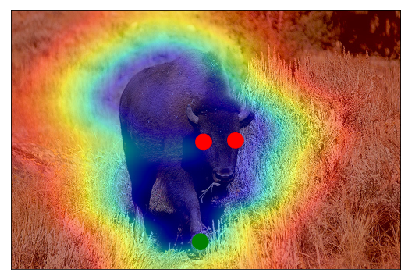

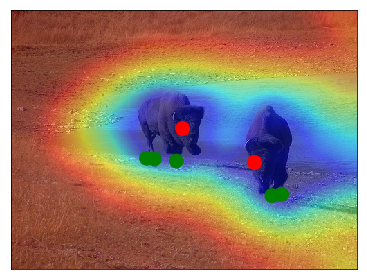

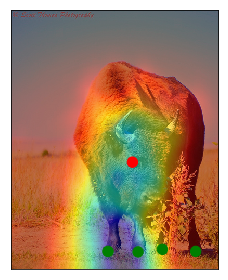

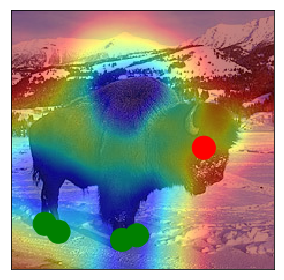

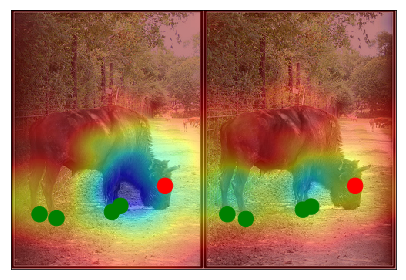

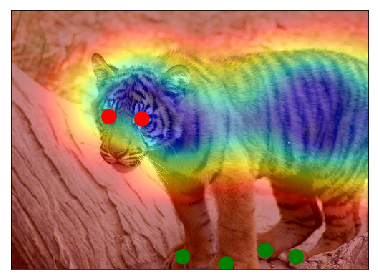

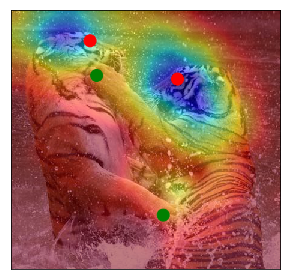

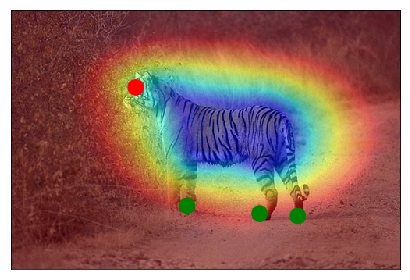

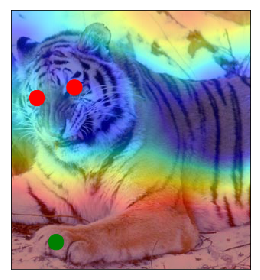

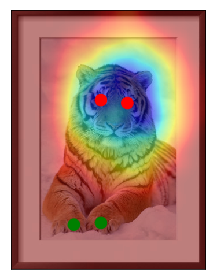

In [11]:
unique_labels = np.unique(labels)
window_size = 5
fig_dir = '/home/ruthfong/neural_coding/paper_figures'
for i in [sorted_idx[0],sorted_idx[-1]]:
    label = unique_labels[i]
    idx = np.where(labels == label)[0]
    
    avg_eyes_intensity = []
    avg_feet_intensity = []
    for j in idx[:5]:
        heatmap = np.load(mask_paths[j])
        resize = caffe.io.load_image(paths[j]).shape[:2]
        heatmap = imresize(heatmap, resize)/float(255)
        #ax.add_patch(patches.Rectangle((x0,y0),x1-x0,y1-y0,linewidth=1,
        #                               edgecolor='r',facecolor='none'))
        f = paths[j].split('/')[-1].strip('.JPEG') + '.xml'
        foot_ann = os.path.join(foot_dir, f)
        eye_ann = os.path.join(eye_dir, f)
        foot_objs = load_objs(foot_ann)
        eye_objs = load_objs(eye_ann)
        
        f, ax = plt.subplots(1,1)
        ax.imshow(caffe.io.load_image(paths[j]))

        num_feet = len(foot_objs['foot'])
        assert(num_feet == foot_num[j])
        #print foot_objs
        for k in range(num_feet):
            (x,y) = foot_objs['foot'][k]
            x, y = int(x), int(y)
            ax.add_artist(plt.Circle((x, y), 10, color='g'))
            avg_intensity = heatmap[y-(window_size-1)/2:y-(window_size-1)/2+window_size, 
                    x-(window_size-1)/2:x-(window_size-1)/2+window_size].sum()/float(window_size**2)
            avg_feet_intensity.append(avg_intensity)
            print 'foot:', avg_intensity
        #print '%d/%d feet in the bounding box' % (foot_included, num_feet)
        num_eyes = len(eye_objs['eye'])
        assert(num_eyes == eye_num[j])
        #print eye_objs
        for k in range(num_eyes):
            (x,y) = eye_objs['eye'][k]
            x, y = int(x), int(y)
            avg_intensity = heatmap[y-(window_size-1)/2:y-(window_size-1)/2+window_size, 
                    x-(window_size-1)/2:x-(window_size-1)/2+window_size].sum()/float(window_size**2)
            avg_eyes_intensity.append(avg_intensity)
            ax.add_artist(plt.Circle((x, y), 10, color='r'))
            print 'eye:', avg_intensity

        ax.imshow(heatmap, alpha = 0.5, cmap = 'jet')
        print avg_eyes_intensity[-1], avg_feet_intensity[-1]
            
        ax.get_xaxis().set_visible(False)                                                                                               
        ax.get_yaxis().set_visible(False)
        #f.subplots_adjust(hspace=0.0,wspace=0.0)
        plt.tight_layout()
        plt.savefig(os.path.join(fig_dir, 'animal_%d_ex_%d.pdf' % (i, j)), bb_inches='tight', pad_inches=0.0)
        #ax.set_title(get_short_class_name(label))

    avg_feet_intensity = np.array(avg_feet_intensity)
    avg_eyes_intensity = np.array(avg_eyes_intensity)

    print avg_eyes_intensity.mean(), avg_feet_intensity.mean()

In [79]:
bb_file = '/data/ruthfong/neural_coding/loc_preds/googlenet_animal_parts_gt_pycaffe/saliency/alpha_5.0_norm_Inf.txt'
bb_data = np.loadtxt(bb_file)
bb_labels = bb_data[:,0].astype(int)
bbs = bb_data[:,1:].astype(int)

(103,)


In [73]:
objs = load_objs('/data/ruthfong/ILSVRC2012/animal_parts_dataset/xml/foot/n02422106_1818.xml')
print objs
print both_idx

{'n02422106': [[113, 43, 438, 359]], 'NaN': [[nan, nan]]}
[]


In [86]:
#unique_parts_labels = np.unique(labels)
unique_parts_labels = np.unique(labels[both_idx])
num_both = np.zeros(unique_parts_labels.shape)
print len(unique_parts_labels)
for i in range(len(unique_parts_labels)):
    label = unique_parts_labels[i]
    num_both[i] = len(np.intersect1d(np.where(labels==label)[0], 
                                                      both_idx))
    print get_short_class_name(label), num_both[i]

103
indigo bunting 86.0
robin 81.0
bulbul 80.0
magpie 64.0
chickadee 207.0
water ouzel 89.0
spotted salamander 69.0
tree frog 124.0
banded gecko 59.0
alligator lizard 70.0
African chameleon 67.0
Komodo dragon 128.0
American alligator 26.0
triceratops 17.0
ruffed grouse 105.0
quail 52.0
African grey 61.0
bee eater 75.0
hummingbird 53.0
jacamar 224.0
toucan 60.0
drake 36.0
tusker 21.0
platypus 23.0
wallaby 27.0
wombat 38.0
spoonbill 87.0
little blue heron 23.0
bittern 38.0
limpkin 29.0
red-backed sandpiper 39.0
oystercatcher 55.0
pelican 31.0
Chihuahua 11.0
Japanese spaniel 3.0
Maltese dog 5.0
Pekinese 12.0
Shih-Tzu 3.0
Blenheim spaniel 7.0
papillon 8.0
toy terrier 5.0
basset 2.0
bloodhound 1.0
redbone 4.0
Ibizan hound 1.0
Norwegian elkhound 1.0
American Staffordshire terrier 1.0
cairn 1.0
standard schnauzer 1.0
silky terrier 1.0
soft-coated wheaten terrier 1.0
flat-coated retriever 1.0
curly-coated retriever 1.0
golden retriever 1.0
Chesapeake Bay retriever 2.0
vizsla 2.0
English setter

In [92]:
len(np.where(num_both >= 10)[0])

76

/data/datasets/ILSVRC2012/images/train/n02129165/n02129165_18958.JPEG 291
/data/ruthfong/ILSVRC2012/images/val/ILSVRC2012_val_00024012.JPEG 19
/data/datasets/ILSVRC2012/images/train/n02119022/n02119022_825.JPEG 277
/data/datasets/ILSVRC2012/images/train/n01817953/n01817953_5869.JPEG 87
/data/datasets/ILSVRC2012/images/train/n01601694/n01601694_6741.JPEG 20


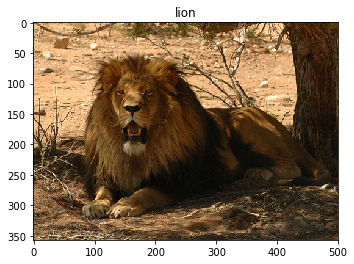

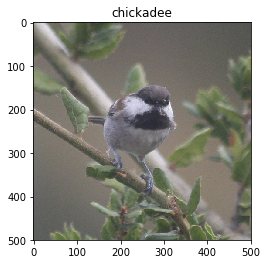

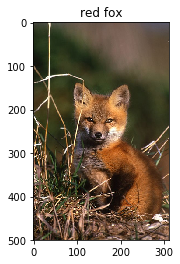

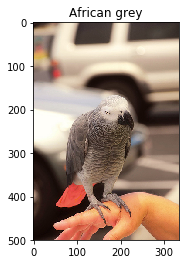

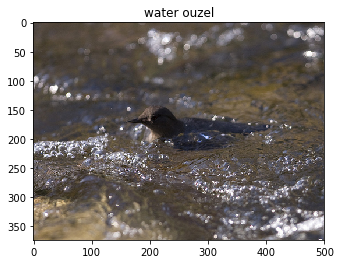

In [34]:
for i in range(55,60):
    f, ax = plt.subplots(1)
    print both_img_paths[i], both_labels[i]
    ax.imshow(caffe.io.load_image(both_img_paths[i]))
    ax.set_title(get_short_class_name(both_labels[i]))

(6,)


/home/ruthfong/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /home/ruthfong/anaconda2/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


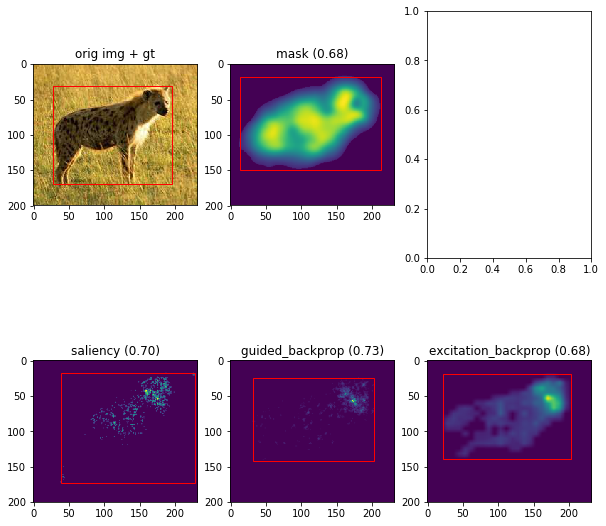

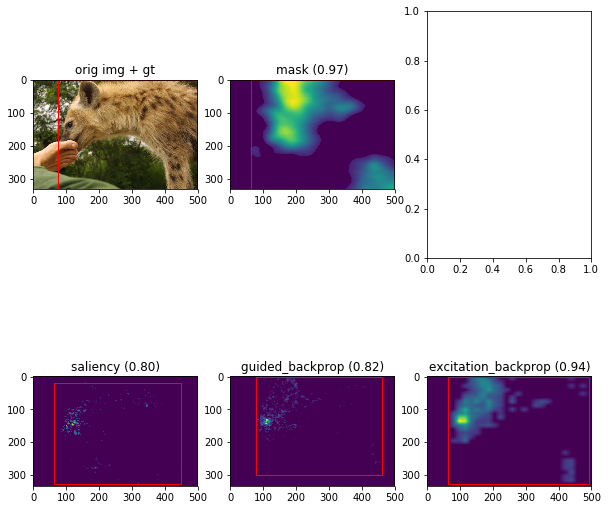

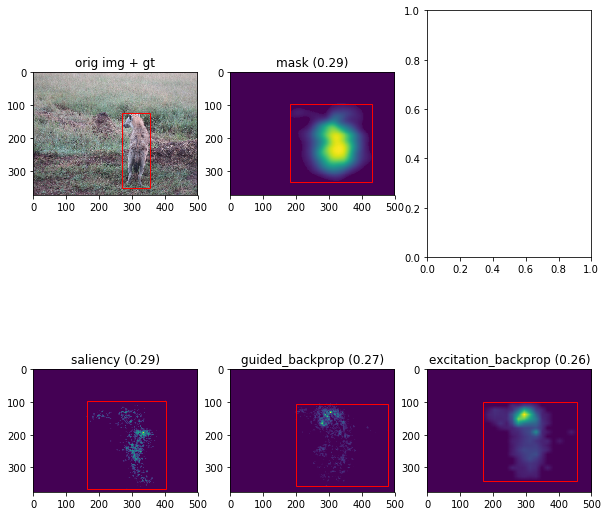

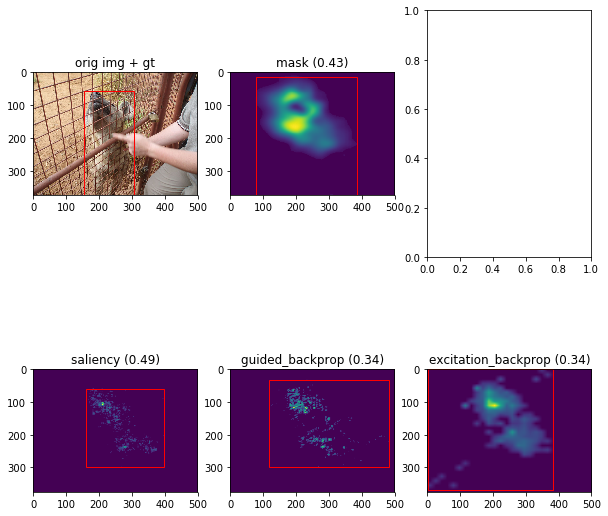

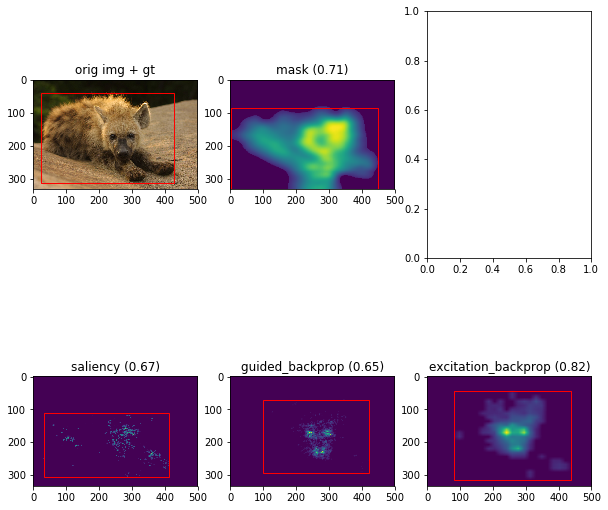

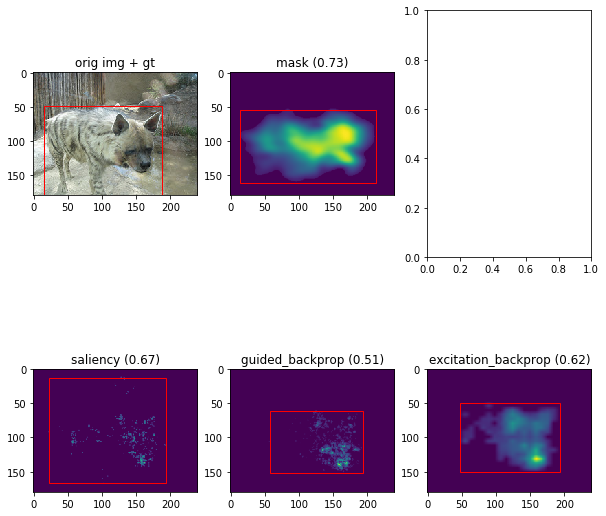

In [20]:
#idx = find_labels('hyena')
#print idx
#print labels_desc[idx]
hyena_i = 276
hyena_idx = np.where(labels == hyena_i)[0]

res_dir = '/data/ruthfong/neural_coding/pycaffe_results'
mask_rel_dir = 'googlenet_train_heldout_given_grad_1_norm_0/min_top5_prob_blur/lr_-1.00_l1_lambda_-3.00_tv_lambda_-inf_l1_lambda_2_-2.00_beta_2.00_mask_scale_8_blur_mask_5_jitter_4_noise_-inf_num_iters_300_tv2_mask_init'

mask_paths = [os.path.join(res_dir, mask_rel_dir, '%d.npy' % x) for x in range(5000)]
mask_alpha = 0.5

%matplotlib inline
for i in range(len(hyena_idx)):
    ind = hyena_idx[i]
    visualize_heatmaps(net, paths[ind], mask_paths[ind], ann_paths[ind], labels[ind], 
                   show_bbs = True, mask_alpha = mask_alpha, mask_flip = True, 
                   thres_first = True, gpu = gpu)

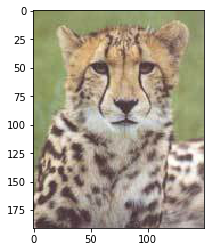

In [14]:
path = '/data/datasets/ILSVRC2012/images/train/n02130308/n02130308_3607.JPEG'
img = caffe.io.load_image(path)
plt.imshow(img)
plt.show()

In [25]:
xml_path = '/data/ruthfong/ILSVRC2012/animal_parts_dataset/xml/eye/n02130308_3607.xml'
anno = load_annotation(xml_path)

data = {}
objs = anno.findAll('object')
for obj in objs:
    obj_names = obj.findChildren('name')
    for name_tag in obj_names:
        label = str(name_tag.contents[0])
        #fname = anno.findChild('filename').contents[0]
        bbox = obj.findChildren('bndbox')[0]
        xmin = int(bbox.findChildren('xmin')[0].contents[0])
        ymin = int(bbox.findChildren('ymin')[0].contents[0])
        xmax = int(bbox.findChildren('xmax')[0].contents[0])
        ymax = int(bbox.findChildren('ymax')[0].contents[0])
        if label in data:
            data[label].append([xmin, ymin, xmax, ymax])
        else:
            data[label] = [[xmin, ymin, xmax, ymax]]
        for point in obj.findChildren('point'):
            x = float(point.findChildren('x')[0].contents[0])
            y = float(point.findChildren('y')[0].contents[0])
            keypoint = str(point.findChildren('class')[0].contents[0])
            if keypoint in data:
                data[keypoint].append([x,y])
            else:
                data[keypoint] = [[x,y]]

In [17]:
objs

[<object>\n<name>n02130308</name>\n<description>cheetah, chetah, Acinonyx jubatus</description>\n<classid>294</classid>\n<bndbox>\n<xmin>1</xmin>\n<ymin>10</ymin>\n<xmax>149</xmax>\n<ymax>190</ymax>\n</bndbox>\n<point>\n<x>98.13</x>\n<y>50.27</y>\n<ambiguous>0</ambiguous>\n<class>eye</class>\n</point>\n<point>\n<x>58.81</x>\n<y>50.74</y>\n<ambiguous>0</ambiguous>\n<class>eye</class>\n</point>\n</object>]

In [26]:
data

{'eye': [[98.13, 50.27], [58.81, 50.74]], 'n02130308': [[1, 10, 149, 190]]}